# **8-1-1**

In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TM.csv')
df1=df.reset_index()['Close']
df1

0        67.78
1        68.43
2        68.62
3        68.51
4        68.42
         ...  
2997    189.78
2998    192.74
2999    187.37
3000    187.99
3001    189.89
Name: Close, Length: 3002, dtype: float64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train, test, validation
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Prepare the data for SVR
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
time_step = 100
# Reshape data into X=t and Y=t+1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)

# Reshape input to be [samples, time steps, features] for SVR
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [6]:
# 6. Create and train SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)  # You can adjust parameters
svr_model.fit(X_train, y_train)

# 7. Predictions
train_predictions = svr_model.predict(X_train)
test_predictions = svr_model.predict(X_test)
val_predictions = svr_model.predict(X_val)


# 8. Evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Evaluate the model
train_rmse, train_mae = evaluate_model(y_train, train_predictions)
test_rmse, test_mae = evaluate_model(y_test, test_predictions)
val_rmse, val_mae = evaluate_model(y_val, val_predictions)

# Print evaluation metrics
print("Train RMSE:", train_rmse, "Train MAE:", train_mae)
print("Test RMSE:", test_rmse, "Test MAE:", test_mae)
print("Validation RMSE:", val_rmse, "Validation MAE:", val_mae)

Train RMSE: 0.038904395604740946 Train MAE: 0.03271822564851054
Test RMSE: 0.10386808451270964 Test MAE: 0.08276401912499798
Validation RMSE: 0.0507904360245968 Validation MAE: 0.038082551629077345


In [7]:
# 8. Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_train, train_predictions)
val_rmse = np.sqrt(mean_absolute_error(y_train, train_predictions))
val_mape = mean_absolute_percentage_error(y_train, train_predictions)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 0.08276401912499798
Testing RMSE: 0.10386808451270964
Testing MAPE: 0.1068354263401557
---------------------------
Validation MAE: 0.03271822564851054
Validation RMSE: 0.180881800213594
Validation MAPE: 0.12989402342778816


In [8]:
# Get the last 'time_step' data points from the validation set to predict the next 30 days
last_sequence = val_data[-time_step:]
next_30_days = []

# Predict the next 30 days
for i in range(30):
    input_sequence = np.array(last_sequence[-time_step:]).reshape(1, -1)
    predicted_price = svr_model.predict(input_sequence)
    next_30_days.append(predicted_price[0])
    last_sequence = np.append(last_sequence, predicted_price[0])

# Inverse transform the scaled predictions to the original scale
predicted_prices = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
print("Predicted Prices for the Next 30 Days:")
print(predicted_prices)


Predicted Prices for the Next 30 Days:
[[172.87599353]
 [171.55422891]
 [170.47027107]
 [169.52314355]
 [168.826066  ]
 [168.02820315]
 [167.20507845]
 [166.44828001]
 [165.71004311]
 [165.06253397]
 [164.58383421]
 [164.19874238]
 [163.73369756]
 [163.22951585]
 [162.79285648]
 [162.20617055]
 [161.66238935]
 [161.19489793]
 [160.69134955]
 [160.20352221]
 [159.75192274]
 [159.36941668]
 [158.86120101]
 [158.2149181 ]
 [157.56418614]
 [156.82387939]
 [156.10291329]
 [155.41859117]
 [154.88105677]
 [154.47986799]]


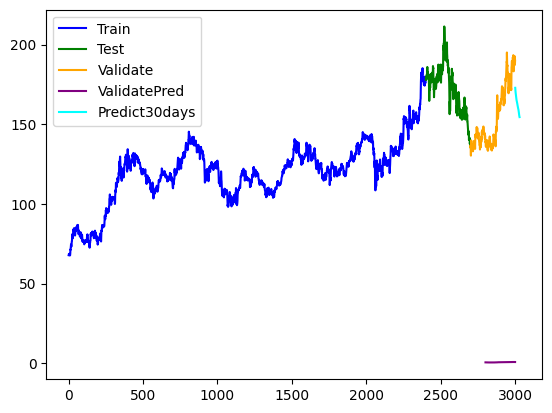

In [9]:
# Plotting combined data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train', color='blue')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test', color='green')

# Add validation data and predictions for validation
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate', color='orange')

val_predicted_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_predicted_index, val_predictions, label='ValidatePred', color='purple')

# Plot predicted prices for the next 30 days
predicted_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(predicted_30_days_index, predicted_prices, label='Predict30days', color='cyan')

plt.legend()
plt.show()

# **7-2-1**

In [10]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TM.csv')
df1=df.reset_index()['Close']
df1

0        67.78
1        68.43
2        68.62
3        68.51
4        68.42
         ...  
2997    189.78
2998    192.74
2999    187.37
3000    187.99
3001    189.89
Name: Close, Length: 3002, dtype: float64

In [12]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
# 4. Chia train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [14]:
# 5. Prepare the data for SVR
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
time_step = 100
# Reshape data into X=t and Y=t+1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)

# Reshape input to be [samples, time steps, features] for SVR
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [15]:
# 6. Create and train SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)  # You can adjust parameters
svr_model.fit(X_train, y_train)

# 7. Predictions
train_predictions = svr_model.predict(X_train)
test_predictions = svr_model.predict(X_test)
val_predictions = svr_model.predict(X_val)

In [16]:
# 8. Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_train, train_predictions)
val_rmse = np.sqrt(mean_absolute_error(y_train, train_predictions))
val_mape = mean_absolute_percentage_error(y_train, train_predictions)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 0.30994993231434387
Testing RMSE: 0.3474435608855134
Testing MAPE: 0.43045755391239193
---------------------------
Validation MAE: 0.03264800658634813
Validation RMSE: 0.18068759389163422
Validation MAPE: 0.13934082687201885


In [17]:
# Get the last 'time_step' data points from the validation set to predict the next 30 days
last_sequence = val_data[-time_step:]
next_30_days = []

# Predict the next 30 days
for i in range(30):
    input_sequence = np.array(last_sequence[-time_step:]).reshape(1, -1)
    predicted_price = svr_model.predict(input_sequence)
    next_30_days.append(predicted_price[0])
    last_sequence = np.append(last_sequence, predicted_price[0])

# Inverse transform the scaled predictions to the original scale
predicted_prices = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
print("Predicted Prices for the Next 30 Days:")
print(predicted_prices)


Predicted Prices for the Next 30 Days:
[[116.50802463]
 [115.62980619]
 [114.65634201]
 [114.00273497]
 [113.5005312 ]
 [112.83488241]
 [112.27871848]
 [111.71203256]
 [111.28805076]
 [110.78281264]
 [110.288896  ]
 [109.81008162]
 [109.29848917]
 [108.93654549]
 [108.58187774]
 [108.22325416]
 [107.97471258]
 [107.70186163]
 [107.41307451]
 [107.12103567]
 [106.84867877]
 [106.60236249]
 [106.4258553 ]
 [106.26951149]
 [106.08077548]
 [105.97716796]
 [105.969969  ]
 [105.89529711]
 [105.82278581]
 [105.7277786 ]]


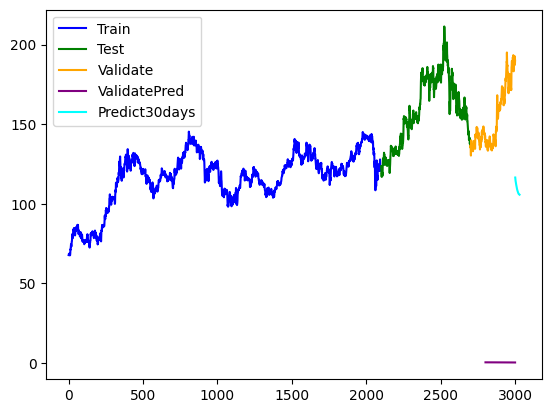

In [18]:
# Plotting combined data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train', color='blue')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test', color='green')

# Add validation data and predictions for validation
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate', color='orange')

val_predicted_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_predicted_index, val_predictions, label='ValidatePred', color='purple')

# Plot predicted prices for the next 30 days
predicted_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(predicted_30_days_index, predicted_prices, label='Predict30days', color='cyan')

plt.legend()
plt.show()

# **6-2-2**

In [19]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TM.csv')
df1=df.reset_index()['Close']
df1

0        67.78
1        68.43
2        68.62
3        68.51
4        68.42
         ...  
2997    189.78
2998    192.74
2999    187.37
3000    187.99
3001    189.89
Name: Close, Length: 3002, dtype: float64

In [21]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [22]:
# 4. Chia train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [23]:
# 5. Prepare the data for SVR
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
time_step = 100
# Reshape data into X=t and Y=t+1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)

# Reshape input to be [samples, time steps, features] for SVR
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [24]:
# 6. Create and train SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)  # You can adjust parameters
svr_model.fit(X_train, y_train)

# 7. Predictions
train_predictions = svr_model.predict(X_train)
test_predictions = svr_model.predict(X_test)
val_predictions = svr_model.predict(X_val)

In [25]:
# 8. Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_train, train_predictions)
val_rmse = np.sqrt(mean_absolute_error(y_train, train_predictions))
val_mape = mean_absolute_percentage_error(y_train, train_predictions)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 0.08809302567821697
Testing RMSE: 0.12572240820826938
Testing MAPE: 0.15197904861764722
---------------------------
Validation MAE: 0.03135891817420748
Validation RMSE: 0.1770844944488576
Validation MAPE: 0.14880904346442572


In [26]:
# Get the last 'time_step' data points from the validation set to predict the next 30 days
last_sequence = val_data[-time_step:]
next_30_days = []

# Predict the next 30 days
for i in range(30):
    input_sequence = np.array(last_sequence[-time_step:]).reshape(1, -1)
    predicted_price = svr_model.predict(input_sequence)
    next_30_days.append(predicted_price[0])
    last_sequence = np.append(last_sequence, predicted_price[0])

# Inverse transform the scaled predictions to the original scale
predicted_prices = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
print("Predicted Prices for the Next 30 Days:")
print(predicted_prices)


Predicted Prices for the Next 30 Days:
[[118.55393286]
 [118.2412665 ]
 [117.97123522]
 [117.69813841]
 [117.45816828]
 [117.25084534]
 [117.07928896]
 [116.90473486]
 [116.7821326 ]
 [116.67453101]
 [116.50578658]
 [116.36801883]
 [116.21626005]
 [116.01803838]
 [115.86941869]
 [115.65888477]
 [115.42313008]
 [115.19179516]
 [114.94105609]
 [114.68598055]
 [114.42002643]
 [114.15962548]
 [113.89065243]
 [113.6141871 ]
 [113.37735857]
 [113.17516017]
 [113.02823219]
 [112.89237187]
 [112.76425392]
 [112.67498859]]


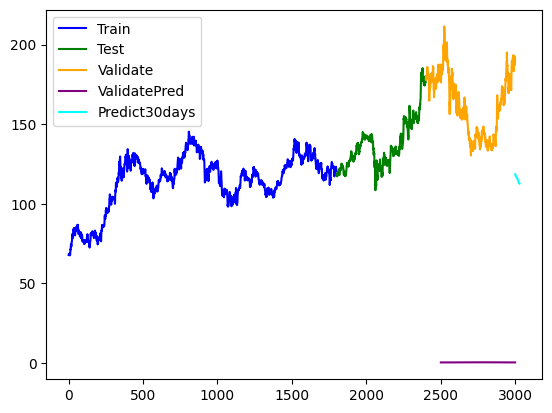

In [27]:
# Plotting combined data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train', color='blue')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test', color='green')

# Add validation data and predictions for validation
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate', color='orange')

val_predicted_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_predicted_index, val_predictions, label='ValidatePred', color='purple')

# Plot predicted prices for the next 30 days
predicted_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(predicted_30_days_index, predicted_prices, label='Predict30days', color='cyan')

plt.legend()
plt.show()